In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
home_dir = '/content/drive/MyDrive/Colab Notebooks/transient_detection/'

In [3]:
sta_name = 'ab48'

['#      annual       0.78  +/-   0.05 mm; phase  -33.2 deg\n', '# semi-annual       0.21  +/-   0.05 mm; phase  163.4 deg\n', '#      annual       0.81  +/-   0.04 mm; phase  22.0 deg\n', '# semi-annual       0.23  +/-   0.04 mm; phase  144.4 deg\n', '#      annual       2.92  +/-   0.11 mm; phase  164.2 deg\n', '# semi-annual       1.06  +/-   0.11 mm; phase  284.4 deg\n']
[[0.78]
 [0.81]
 [2.92]]
[[-33.2]
 [ 22. ]
 [164.2]]
[[0.21]
 [0.23]
 [1.06]]
[[163.4]
 [144.4]
 [284.4]]


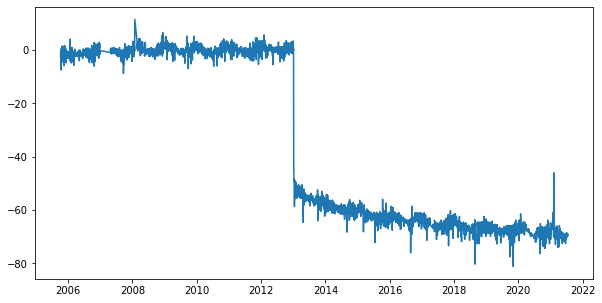

In [4]:
def read_timeseries(file_path):
  file_path = home_dir + 'raw_data/filter_detrend/' + sta_name + 'FilterDetrend.neu'
  fid = open(file_path)

  buffer = []
  while True:
    line = fid.readline()
    
    if line[0]!='#':
        break

    if 'annual' in line:  
        buffer.append(line.replace(':', ' '))
  fid.close()
  print(buffer)

  a1 = np.zeros((3,1))
  p1 = np.zeros((3,1))
  a2 = np.zeros((3,1))
  p2 = np.zeros((3,1))

  for i in range(3):
    c = buffer[2*i].split()
    a1[i] = c[2]
    p1[i] = c[7]

    c = buffer[2*i + 1].split()
    a2[i] = c[2]
    p2[i] = c[7]

  print(a1)
  print(p1)
  print(a2)
  print(p2)

  df = pd.read_table(file_path,sep='\s+',float_precision='round_trip',comment='#',names=['DecYr','Yr','DoY','N','E','U','Nsig','Esig','Usig', 'CorrNE', 'CorrNU', 'CorrEU','unknown'])
  t = df['DecYr'].to_numpy()
  d = np.zeros((3,t.size))
  d[0,:] = df['E'].to_numpy()
  d[1,:] = df['N'].to_numpy()
  d[2,:] = df['U'].to_numpy()

  d_seasonal = a1*np.sin(2*np.pi*t + p1/180*np.pi) + a2*np.sin(4*np.pi*t + p2/180*np.pi) 

  return t, d - d_seasonal


t, d = read_timeseries(sta_name)

plt.figure(figsize=(10,5))
plt.plot(t, d[0,:], '-')
#plt.xlim(2006, 2012)
#plt.ylim(-10, 10)
plt.show()

In [5]:
import tensorflow as tf

In [6]:
model = tf.keras.models.load_model(home_dir+'model/sequence_model_0_mask.h5')

In [7]:
from sklearn.preprocessing import minmax_scale
from scipy.signal import detrend

def scale(data):
  return minmax_scale(detrend(data, axis=1), axis=1)

In [8]:
def predict_1sta(timeseries):
  
  d = timeseries.copy()
  prob = np.zeros(d.shape)

  d[np.isnan(d)] = 0

  valid_epochs = np.nonzero(d)[0]
  epoch_start = valid_epochs[0]
  epoch_end = valid_epochs[-1]

  d = scale(d[np.newaxis, epoch_start:epoch_end])

  valid_probs = np.squeeze(model.predict(d[:,:,np.newaxis]))
  prob[epoch_start:epoch_end] = valid_probs
  return prob

In [9]:
prob_n = predict_1sta(d[0,:])

In [10]:
plt.rcParams['font.size'] = '12'

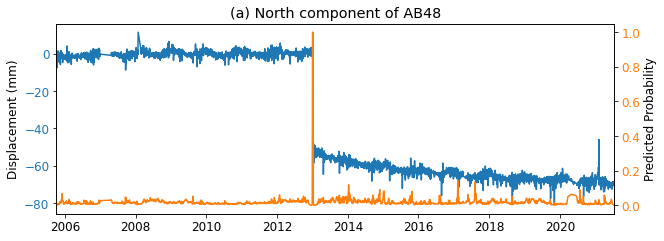

In [12]:
fig = plt.figure(figsize=(10,3.5))
ax1 = fig.subplots()

color = 'tab:blue'
ax1.plot(t, d[0,:], '-', color=color)
ax1.set_xlim(t[0], t[-1])
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Displacement (mm)')

color = 'tab:orange'
ax2 = ax1.twinx()
ax2.plot(t, prob_n, '-', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Predicted Probability')
plt.title('(a) North component of AB48')
#plt.show()
plt.savefig('ab48.pdf', format='pdf',bbox_inches='tight', pad_inches=0.05)